In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import platform
import keras
from keras import models 
from keras import layers
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np

print("python version       :" + platform.python_version())
print("keras version        :" + keras.__version__)
print("tensorflow version   :" + tf.__version__)
strategy = tf.distribute.MirroredStrategy()
print("Number of GPU devices: {}".format(strategy.num_replicas_in_sync))

python version       :3.8.5
keras version        :2.4.3
tensorflow version   :2.2.0
INFO:tensorflow:Using MirroredStrategy with devices (&#39;/job:localhost/replica:0/task:0/device:GPU:0&#39;, &#39;/job:localhost/replica:0/task:0/device:GPU:1&#39;)
Number of GPU devices: 2


In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()
train_data.shape
test_data.shape

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std


(404, 13)

(102, 13)

In [3]:
def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    plot_model(model, to_file='models1.png', show_shapes=True, show_layer_names=True)
    plt.imshow(mpimg.imread("models.png"))
    return model

processing fold # 0
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to (&#39;/job:localhost/replica:0/task:0/device:CPU:0&#39;,).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to (&#39;/job:localhost/replica:0/task:0/device:CPU:0&#39;,).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to (&#39;/job:localhost/replica:0/task:0/device:CPU:0&#39;,).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to (&#39;/job:localhost/replica:0/task:0/device:CPU:0&#39;,).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to (&#39;/job:localhost/replica:0/task:0/device:CPU:0&#39;,).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0

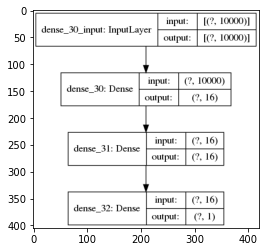

In [4]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []

all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    with strategy.scope():
        # Build the Keras model (already compiled)
        model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

4

2.6805639438033104

500

[&lt;matplotlib.lines.Line2D at 0x7fac68296580&gt;]

Text(0.5, 0, &#39;Epochs&#39;)

Text(0, 0.5, &#39;Validation MAE&#39;)

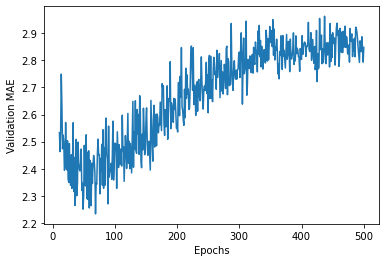

In [7]:
len(all_mae_histories)
np.mean(all_mae_histories)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
len(average_mae_history)
#average_mae_history = range(100)
#average_mae_history
plt.plot(range(11, len(average_mae_history) + 1), average_mae_history[10:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

[&lt;matplotlib.lines.Line2D at 0x7fac683a9e20&gt;]

Text(0.5, 0, &#39;Epochs&#39;)

Text(0, 0.5, &#39;Validation MAE&#39;)

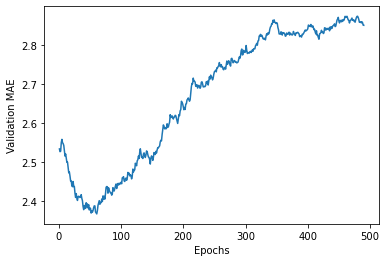

In [6]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()